# Pose-Graph SLAM Comparison to Dead Reckoning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from slam import *

np.random.seed(3)  # stable example

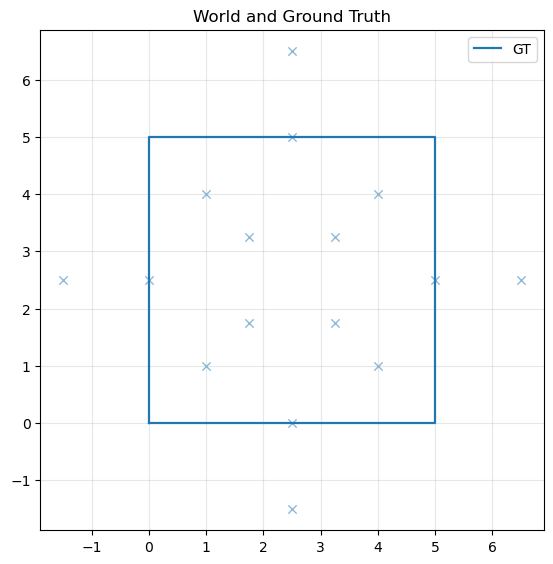

In [2]:
# Create simple world
world = make_simple_world()

# Define robot and the various covariances for its measurements
sensor_range = 0.9 * (np.sqrt(2)*world.side_length)  # see many LMs on each side
odom_cov = np.diag([0.03**2, 0.03**2, (np.deg2rad(1.0))**2])
range_bearing_cov = np.diag([0.20**2, (np.deg2rad(2.0))**2])
loop_closure_cov = 0.2 * odom_cov
robot = Robot(odom_cov=odom_cov, 
              range_bearing_cov=range_bearing_cov, 
              loop_closure_cov=loop_closure_cov, 
              sensor_range=sensor_range)

# Simulate a square trajectory and compute simulated measurements
dt = 0.1
controls = square_loop_control_sequence(world, v=0.25, dt=dt)
x_gt, odom_meas, lm_meas, lc_meas = simulate(robot, world, controls, dt)

# Plot the world's landmarks and ground truth robot trajectory
plot_traj("World and Ground Truth", {"GT": x_gt}, world)

### Odometry-Only Localization (Dead Reckoning)
In this first example we have the simplest and least accurate approach that is based on only odometry measurements where the robot is using its own sensors to estimate its motion (e.g. using wheel encoders). Specifically, we use the `odom_meas` outputs from the robot's simulated trajectory computed above.

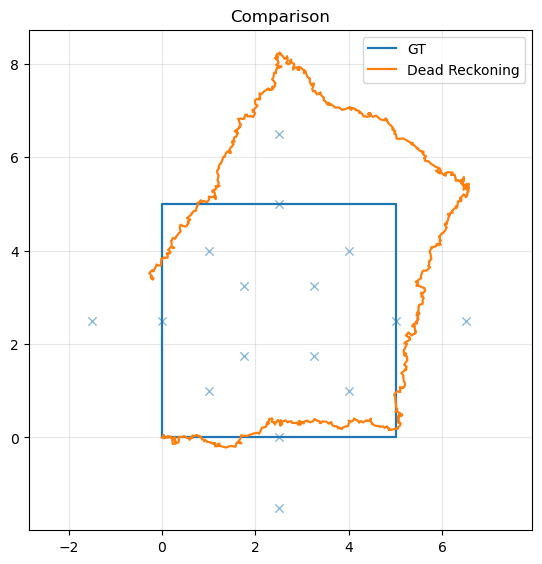

=== Error metric and execution time ===
Odometry only: 2.352 m, time: 11.63 ms


In [3]:
def dead_reckoning(odom_meas: np.ndarray) -> np.ndarray:
    T = odom_meas.shape[0]
    x = np.zeros((T+1, 3))
    for t, rel in enumerate(odom_meas):
        x[t+1] = se2_compose(x[t], rel)
    return x

# Compute odometry based trajectory estimate and compare to ground-truth
start_time = time.perf_counter()
x_odom = dead_reckoning(odom_meas)
time_odom = time.perf_counter() - start_time
plot_traj("Comparison", {"GT": x_gt, "Dead Reckoning": x_odom}, world)
rmse_odom = absolute_trajectory_rmse(x_gt, x_odom)
print("=== Error metric and execution time ===")
print(f"Odometry only: {rmse_odom:.3f} m, time: {1000*time_odom:.2f} ms")

### Smoothing-based Approach: Pose-graph SLAM
In this next approach we will use a smoothing base approach called Pose Graph SLAM that performs a global optimization problem given all data, rather than the incremental approaches of the filter-based EKF SLAM.

In [4]:
def se2_rel_residual(pred_rel, meas_rel):
    """
    Residual where translation error is expressed in the *measurement frame*;
    angle is wrapped difference. This stabilizes GN.
    r = [ Rz(-meas_th) * (pred_xy - meas_xy) ; wrap(pred_th - meas_th) ]
    """
    dxy = pred_rel[:2] - meas_rel[:2]
    r_xy = rotation(-meas_rel[2]) @ dxy
    r_th = wrap_angle(pred_rel[2] - meas_rel[2])
    return np.array([r_xy[0], r_xy[1], r_th])

def pose_graph_optimize(robot: Robot,
                        odom_meas: np.ndarray,
                        use_loop_closure: bool,
                        lc_meas: Optional[np.ndarray],
                        iters: int = 10,
                        lm_lambda: float = 1e-3) -> np.ndarray:
    """
    Weighted Gauss–Newton with LM damping.
    Variables: X_0..X_T ; fix X_0 gauge by removing its columns.
    Edges: odometry (t->t+1) and optional LC (0<->T).
    Numerical Jacobians (fine for small/medium T).
    """
    T = odom_meas.shape[0]
    X = dead_reckoning(odom_meas)  # initializer

    # Weight matrices
    W_odom = np.linalg.inv(robot.odom_cov)
    W_lc = np.linalg.inv(robot.loop_closure_cov) if use_loop_closure else None

    def residual_and_jac(X):
        res_blocks, J_blocks, W_blocks = [], [], []
        eps = 1e-6
        # Odometry edges
        for t in range(T):
            pred = se2_between(X[t], X[t+1])
            r = se2_rel_residual(pred, odom_meas[t])
            # Numeric Jacobians wrt X_t and X_{t+1}
            Jb = np.zeros((3, 3*(T+1)))
            for (idx, sign) in [(t, 1), (t+1, 1)]:
                for k in range(3):
                    Xp = X.copy()
                    Xp[idx, k] += eps
                    p1 = se2_between(Xp[t], Xp[t+1])
                    r1 = se2_rel_residual(p1, odom_meas[t])
                    Xp[idx, k] -= 2*eps
                    p2 = se2_between(Xp[t], Xp[t+1])
                    r2 = se2_rel_residual(p2, odom_meas[t])
                    Jb[:, 3*idx + k] = (r1 - r2) / (2*eps)
            res_blocks.append(r); J_blocks.append(Jb); W_blocks.append(W_odom)
        # Loop-closure edge
        if use_loop_closure and lc_meas is not None and W_lc is not None:
            pred = se2_between(X[0], X[T])
            r = se2_rel_residual(pred, lc_meas)
            Jb = np.zeros((3, 3*(T+1)))
            for idx in [0, T]:
                for k in range(3):
                    Xp = X.copy()
                    Xp[idx, k] += eps
                    p1 = se2_between(Xp[0], Xp[T])
                    r1 = se2_rel_residual(p1, lc_meas)
                    Xp[idx, k] -= 2*eps
                    p2 = se2_between(Xp[0], Xp[T])
                    r2 = se2_rel_residual(p2, lc_meas)
                    Jb[:, 3*idx + k] = (r1 - r2) / (2*eps)
            res_blocks.append(r); J_blocks.append(Jb); W_blocks.append(W_lc)

        # Stack (block-diag weights)
        R = np.hstack([rb for rb in res_blocks])  # shape (3E,)
        J = np.vstack(J_blocks)                   # shape (3E, 3*(T+1))
        W = np.zeros((3*len(W_blocks), 3*len(W_blocks)))
        for i, Wi in enumerate(W_blocks):
            W[3*i:3*(i+1), 3*i:3*(i+1)] = Wi
        return R, J, W

    for i in range(iters):
        R, J, W = residual_and_jac(X)
        # Fix the gauge by removing columns of X0
        mask = np.ones(J.shape[1], dtype=bool); mask[0:3] = False
        Jred = J[:, mask]
        # Weighted normal equations with LM damping
        A = Jred.T @ W @ Jred + lm_lambda * np.eye(Jred.shape[1])
        b = -Jred.T @ W @ R
        dx = np.linalg.lstsq(A, b, rcond=None)[0]
        Xv = X.reshape(-1)
        Xv[3:] += dx
        X = Xv.reshape(-1, 3)
        X[:,2] = np.array([wrap_angle(a) for a in X[:,2]])
    return X

Now run the Pose-graph SLAM with and without loop closure below. Note this may take a while to run. Given only the odometry measurements and no loop closure, the pose-graph solution should look like the dead recknoning estimate, but when adding the loop closure measurement it should drastically improve.

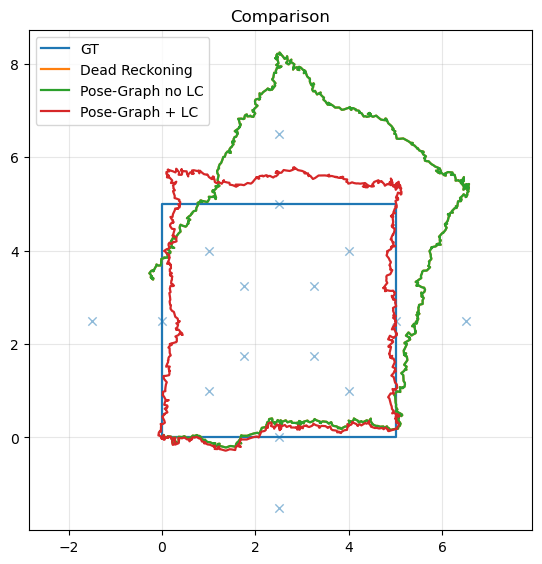

=== Error metric and execution time ===
Odometry only      : 2.352 m, time: 11.63 ms
Pose-graph (no LC) : 2.352 m, time: 114874.46 ms
Pose-graph (+ LC)  : 0.470 m, time: 109889.94 ms


In [5]:
# Run Pose-graph SLAM without loop closure
start_time = time.perf_counter()
x_pg_no_lc = pose_graph_optimize(robot, odom_meas, use_loop_closure=False, lc_meas=None, iters=12, lm_lambda=2e-3)
time_pg_no_lc = time.perf_counter() - start_time

# Run Pose-graph SLAM with loop closure
start_time = time.perf_counter()
x_pg_lc = pose_graph_optimize(robot, odom_meas, use_loop_closure=True, lc_meas=lc_meas, iters=12, lm_lambda=2e-3)
time_pg_lc = time.perf_counter() - start_time

# Compare results
plot_traj("Comparison", {"GT": x_gt, 
                         "Dead Reckoning": x_odom, 
                         "Pose-Graph no LC": x_pg_no_lc,
                         "Pose-Graph + LC": x_pg_lc}, world)
rmse_pg_no_lc = absolute_trajectory_rmse(x_gt, x_pg_no_lc)
rmse_pg_lc = absolute_trajectory_rmse(x_gt, x_pg_lc)
print("=== Error metric and execution time ===")
print(f"Odometry only      : {rmse_odom:.3f} m, time: {1000*time_odom:.2f} ms")
print(f"Pose-graph (no LC) : {rmse_pg_no_lc:.3f} m, time: {1000*time_pg_no_lc:.2f} ms")
print(f"Pose-graph (+ LC)  : {rmse_pg_lc:.3f} m, time: {1000*time_pg_lc:.2f} ms")